# Chapter 4. Training Models

In this chapter, we will work with a linear model and train it using the closed-form solution and several types of gradient descent.
Then, we will graduate to a polynomial and look for overfitting.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(0)

plt.style.use('seaborn-whitegrid')
plt.rc('figure', figsize=(8, 5), facecolor='white')

In [2]:
%matplotlib inline

## Linear regression

### The normal equation

There is a closed form solution for finding the line that minimizes the RMSE of data to a single response variable.

In [3]:
X = 2 * np.random.rand(100, 1)
X[1:5]

array([[1.43037873],
       [1.20552675],
       [1.08976637],
       [0.8473096 ]])

In [4]:
y = 4 + 3 * X + np.random.randn(100, 1)
y[1:5]

array([[9.19196269],
       [8.0822427 ],
       [5.73305541],
       [8.03018099]])

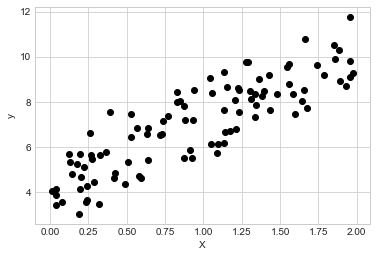

In [5]:
plt.scatter(X, y, color='black')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

We will first compute the exact minimization of RMSE (really, MSE) by solving the *Normal Equation*, below.

$$
\hat{\theta} = (\boldsymbol{\text{X}}^T \cdot \text{X})^{-1} \cdot \text{X}^T \cdot \text{y}
$$

In [6]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.22215108],
       [2.96846751]])

These values can be used for making predictions given new data points.

In [7]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.22215108],
       [10.1590861 ]])

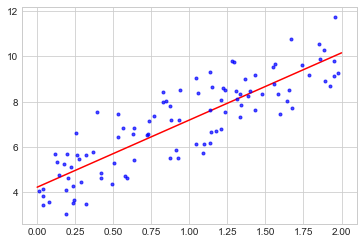

In [8]:
plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b.', alpha=0.7)
plt.show()

This, of course, can be more easily (and safely) done with Scikit-Learn.

In [9]:
from sklearn.linear_model import LinearRegression

# Fit an Scikit-Learn linear regression model.
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# The intercept of the fit model.
lin_reg.intercept_

array([4.22215108])

In [10]:
lin_reg.coef_

array([[2.96846751]])

In [11]:
# Make predictions for new data.
lin_reg.predict(X_new)

array([[ 4.22215108],
       [10.1590861 ]])

### Gradient Descent

There are other ways to fit a linear model that are better suited for many features.

The main idea behind *gradient descent* is to tweak parameters towards minimizing some objective function.
An important parameter is the *learning rate* which determines the step size of the optimization.
Also, there may be local minima that trap the optimization.

It is generally good advice to have scaled features for gradient descent such that all dimensions are related in scale.

### Batch gradient descent

The find the best direction to move, the partial derivative must be found for each dimension.
This is done manually below, but of course it can be done quickly using the appropriate Scikit-Learn solver.
The equation for the partial derivative is below:

$$
\nabla_{\theta}\text{MSE}(\theta) =
\begin{pmatrix}
    {\frac{\partial}{\partial \theta_0}\text{MSE}(\theta)} \\
    {\frac{\partial}{\partial \theta_1}\text{MSE}(\theta)} \\
    {...} \\
    {\frac{\partial}{\partial \theta_n}\text{MSE}(\theta)} \\
    \end{pmatrix} =
\frac{2}{m}\text{X}^T \cdot (\text{X} \cdot \theta -\text{y})
$$

In [12]:
eta = 0.1  # learning rate
n_iterations = 1000  # number of iterations of gradient descent
m = X.shape[0]  # number of data points

theta = np.random.randn(2, 1) # randomly initialize theta

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    
theta

array([[4.22215108],
       [2.96846751]])

The see the effect of the learning rate, I built a function that plots the line generated at each step.

In [13]:
def get_styling_details(current_iteration, max_iterations):
    """Get the styling details for the line plot depending on the iteration."""
    if current_iteration == 0:
        return ('r--', 1)
    elif current_iteration == max_iterations:
        return ('b-', 1.0)
    elif current_iteration < 10:
        return ('b--', 0.3)
    else:
        return ('k-', 0.0)


def plot_current_line(theta, current_iteration, max_iterations):
    """Plot the current line."""
    style, alpha = get_styling_details(current_iteration, max_iterations)
    y_predict = X_new_b.dot(theta)
    plt.plot(X_new, y_predict, style, alpha=alpha)


def plot_gradient_descent(theta, eta):
    """Perform gradient descent and plot the intermediates."""
    
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    
    for iteration in range(n_iterations):
        if iteration < 10 or iteration == n_iterations-1 :
            plot_current_line(theta, iteration, n_iterations-1)
        
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
    
    plt.xlabel('$X$', fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(f'$\eta = {eta}$', fontsize=16)

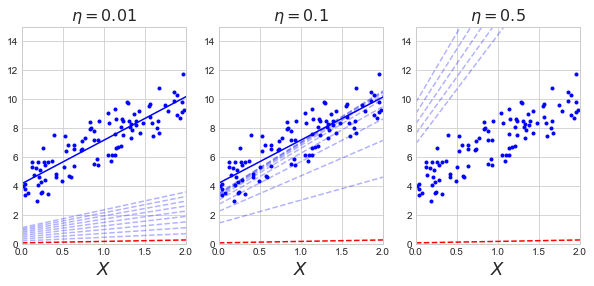

In [14]:
random_initial_theta = np.array([[0.1], [0.1]])
fig = plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plot_gradient_descent(random_initial_theta, 0.01)
plt.subplot(1, 3, 2)
plot_gradient_descent(random_initial_theta, 0.1)
plt.subplot(1, 3, 3)
plot_gradient_descent(random_initial_theta, 0.5)

In practice, a good learning reate can be found with a grid search.
A limit on the number of iterations will ensure that the optimization converges at an acceptable rate.
The actual number of iterations for the model can be a relatively large number, but stop the optimization when a sufficiently good answer has been found.
That is, interrupt the algorithm when the gradient vector is smaller than a provided tolerance $\epsilon$.

### Stochastic gradient descent

Batch gradient descent uses every piece of the training data to optimize the model parameters.
On the other extreme, SGD uses a single, random data point in the training data at each step.
Therefore, it bounces around, and only moves towards the solution on average.
Due to this bouncing nature, it is unlikely that SGD will be as accurate as batch gradient descent.
It will me much faster, though, especially with a large data set.
This property of SGD also helps it bounce out of local minima.

Gradually reducing the learning rate can help with the bouncing problem.
This is called *simulated annealing*.
The function that controls the learning rate is called the *learning schedule*.

The code below implements a simple SGD algorithm.

array([[4.21493839],
       [2.957017  ]])

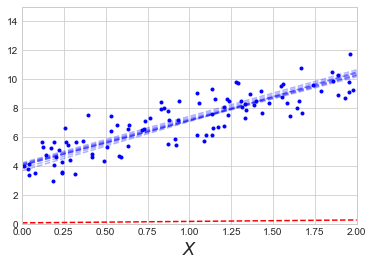

In [15]:
n_epochs = 50

# Hyperparamters for the learning schedule.
t0 = 5
t1 = 50

m = X.shape[0]  # number of data points

theta = np.array([[0.1], [0.1]])  # Iinital values for theta.

def learning_schedule(t):
    """A learncing schedule for SGD."""
    return t0 / (t + t1)

plt.plot(X, y, "b.")

plot_current_line(theta, 0, n_epochs)

for epoch  in range(1, n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta =  learning_schedule(epoch * m + 1)
        theta = theta - eta * gradients
    plot_current_line(theta, epoch, n_epochs)

plt.xlabel('$X$', fontsize=18)
plt.axis([0, 2, 0, 15])

# The final optimized solution.
theta

The equivalent can be done using the Scikit-Learn `SGDRegressor` class.

In [16]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X, y.ravel())

# Solutions.
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21182999]), array([2.9989967]))

### Mini-batch gradient descent

At each step, a random subsample of the data is used to compute the gradient.
It is therefore more erratic than batch gradient descent and less so than SGD.

Below, I plot the three gradient descent algorithms paths through parameter space to solve the sample linear regression in the chapter.

In [17]:
def learning_schedule(t, t0=10, t1=50):
    """A learncing schedule for SGD."""
    return t0 / (t + t1)

def my_batch_gd(theta_0, epoch_number, eta = 0.1):
    """Calculate the next theta using batch gradient descent."""
    gradients = 2/m * X_b.T.dot(X_b.dot(theta_0) - y)
    theta = theta_0 - eta * gradients
    return theta


def my_stochastic_gd(theta_0, epoch_number):
    """Calculate the next theta using stochastic gradient descent."""
    theta = theta_0
    for i in range(X.shape[0]):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch_number * m + 1)
        theta = theta - eta * gradients
    return theta


def my_minibatch_gd(theta_0, epoch_number, batch_size=5):
    """Calculate the next theta using minibatch gradient descent."""
    theta = theta_0
    m = X.shape[0]
    n_iters = round(m / batch_size)
    for i in range(n_iters):
        random_index = np.random.randint(m, size=batch_size)
        xi = X_b[random_index]
        yi = y[random_index]
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        eta = learning_schedule(epoch_number * m + 1)
        theta = theta - eta * gradients
    return theta

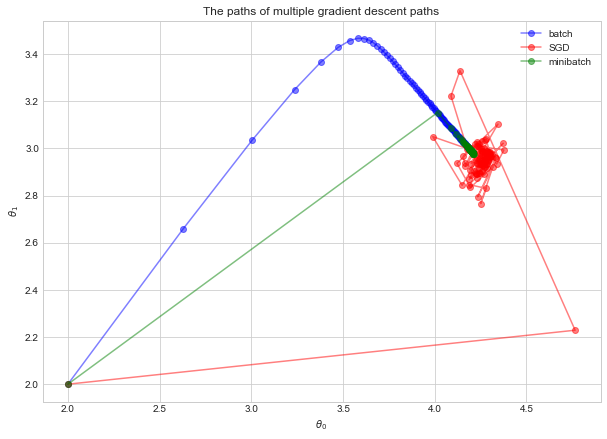

In [18]:
# Initial values for theta.
initial_theta = np.array([[2.0], [2.0]])


def run_my_gradient_descent(descent_func, theta_i, n_iterations=100):
    """
    Return all of the intermediate theta values while running the
    specified gradient descent algorithm
    """
    thetas = initial_theta.copy()
    next_theta = initial_theta.copy()
    for iteration in range(n_iterations):
        next_theta = descent_func(next_theta, iteration)
        thetas = np.hstack([thetas, next_theta])

    thetas = thetas.T
    return thetas


# Batch GD
batch_thetas = run_my_gradient_descent(my_batch_gd, initial_theta)

# SGD
sgd_thetas = run_my_gradient_descent(my_stochastic_gd, initial_theta)

# Minibatch GD
minibatch_thetas = run_my_gradient_descent(my_minibatch_gd, initial_theta)

# Plot the results on the sample plot.
fig = plt.figure(figsize = (10, 7))
plt.plot(batch_thetas[:, 0], batch_thetas[:, 1],
         label='batch',
         linestyle='-', marker='o', color='blue', 
         alpha=0.5)
plt.plot(sgd_thetas[:, 0], sgd_thetas[:, 1],
         label='SGD',
         linestyle='-', marker='o', color='red', 
         alpha=0.5)
plt.plot(minibatch_thetas[:, 0], minibatch_thetas[:, 1],
         label='minibatch',
         linestyle='-', marker='o', color='green', 
         alpha=0.5)
plt.title('The paths of multiple gradient descent paths')
plt.legend(loc='best')
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.show()

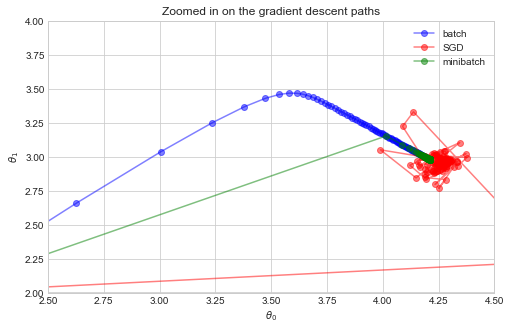

In [19]:
fig = plt.figure(figsize = (8, 5))
plt.plot(batch_thetas[:, 0], batch_thetas[:, 1],
         label='batch',
         linestyle='-', marker='o', color='blue', 
         alpha=0.5)
plt.plot(sgd_thetas[:, 0], sgd_thetas[:, 1],
         label='SGD',
         linestyle='-', marker='o', color='red', 
         alpha=0.5)
plt.plot(minibatch_thetas[:, 0], minibatch_thetas[:, 1],
         label='minibatch',
         linestyle='-', marker='o', color='green', 
         alpha=0.5)
plt.axis([2.5, 4.5, 2, 4])
plt.title('Zoomed in on the gradient descent paths')
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.legend(loc='best')
plt.show()

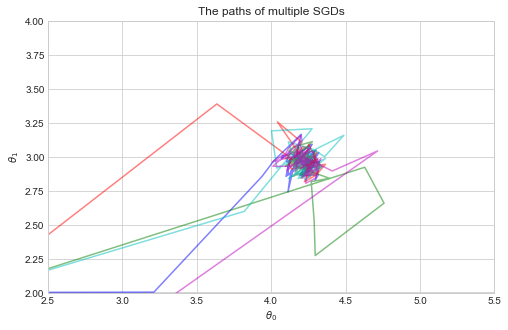

In [20]:
colors = ['b', 'g', 'r', 'c', 'm']

    
fig = plt.figure(figsize=(8, 5))
for i in range(5):
    thetas = run_my_gradient_descent(my_stochastic_gd, initial_theta)
    plt.plot(thetas[:, 0], thetas[:, 1], color=colors[i], alpha = 0.5)

plt.title('The paths of multiple SGDs')
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.axis([2.5, 5.5, 2, 4])
plt.show()

## Polynomial regression

It is possible to fit nonlinear data with a linear model by adding powers of each feature as new features.
This is polynomial regression.
An example is below.

In [21]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

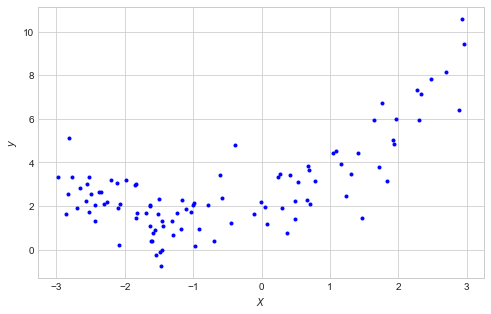

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(X, y, 'b.')
plt.xlabel(r'$X$')
plt.ylabel(r'$y$')
plt.show()

Here is the result of trying to fit a linear model to this nonlinear data.

In [23]:
# Fit a linear model.
lin_reg = LinearRegression()
lin_reg.fit(X, y)

# Results.
lin_reg.coef_, lin_reg.intercept_

(array([[0.81860005]]), array([3.25226041]))

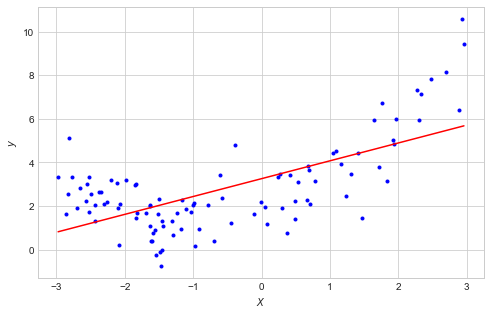

In [24]:
X_range = np.array([np.min(X), np.max(X)]).reshape((2, 1))
y_predict_range = lin_reg.predict(X_range)

plt.figure(figsize=(8, 5))
plt.plot(X, y, 'b.')
plt.plot(X_range, y_predict_range, 'r-')
plt.xlabel(r'$X$')
plt.ylabel(r'$y$')
plt.show()

Instead, a polynomial regression fits much better.
The `PolynomialFeatures` class can add in the new squared features for each existing feature.

In [25]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

X[0]

array([-2.85578399])

In [26]:
X_poly[0]

array([-2.85578399,  8.1555022 ])

In [27]:
# Fit a linear model.
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

# Results.
lin_reg.intercept_, lin_reg.coef_

(array([1.88737162]), array([[0.96860865, 0.47143241]]))

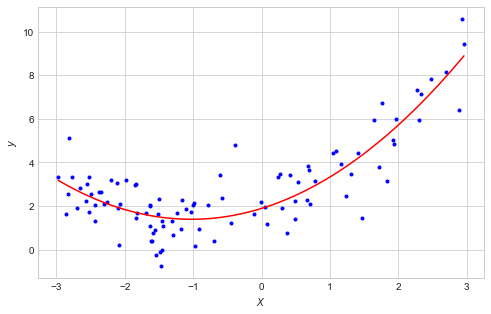

In [28]:
n_points = 1000
X_new = np.linspace(np.min(X), np.max(X), n_points).reshape((n_points, 1))
X_new = poly_features.transform(X_new)
y_predict = lin_reg.predict(X_new)

plt.figure(figsize=(8, 5))
plt.plot(X, y, 'b.')
plt.plot(X_new[:, 0], y_predict, 'r-')
plt.xlabel(r'$X$')
plt.ylabel(r'$y$')
plt.show()

### Learning curves

It is easy to overfit a polynomial regression.
Below are the results of continuously increasing the degree of the model.

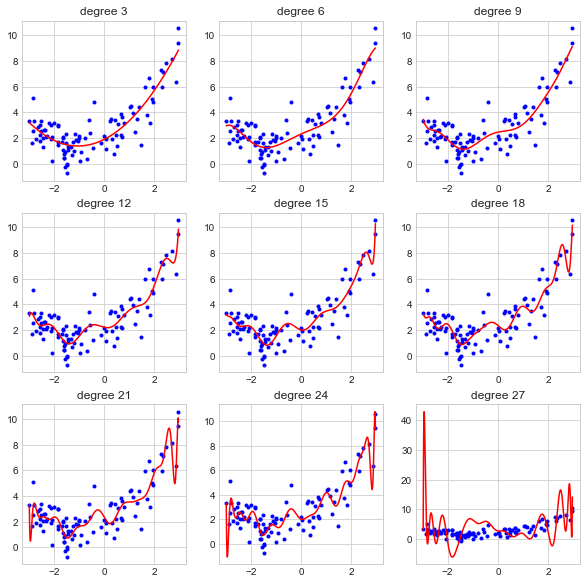

In [29]:
def fit_polynomial_regression_to_X(deg=1):
    # Prepare input data.
    poly_transformer = PolynomialFeatures(degree=deg, include_bias=False)
    X_input = poly_transformer.fit_transform(X)
    
    # Fit model.
    lr = LinearRegression()
    lr.fit(X_input, y)
    
    j = 1000
    predicted_y = np.linspace(np.min(X), np.max(X), j).reshape((j, 1))
    predicted_y = poly_transformer.transform(predicted_y)
    y_predict = lr.predict(predicted_y)

    plt.plot(X, y, 'b.')
    plt.plot(predicted_y[:, 0], y_predict, 'r-')
    plt.title(f'degree {deg}')

    
fig = plt.figure(figsize=(10, 10))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    fit_polynomial_regression_to_X(i * 3)

plt.show()

One way of telling if the model is under- or overfitting is to use CV.
Another way is to look at the *learning curves*, the plot of the models performance on the training set and validation set as a function of the training set size.
The plots are generated by repeatedly training the model on differently-sized subsets of the training data.

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split    

def plot_learning_curve(model, X, y, subsample_iters=1):
    """Plot the learning curve of a model on training data X and labels y."""
    
    # Split the data into testing and validation.
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    
    # Empty lists to track progress.
    train_errors, val_errors = [], []
    
    # For each subsample from 1 to all of the training data, run
    # `subsample_iters` iterations and take the average for the subsample size.
    for m in range(1, len(X_train)):
        train_errors_iter, val_errors_iter = [], []
        for j in range(subsample_iters):
            # Random subsample of size `m`.
            idx = np.random.randint(1, len(X_train), m)
            
            # Fit and predict with model.
            model.fit(X_train[idx], y_train[idx])
            y_train_predict = model.predict(X_train[idx])
            y_val_predict = model.predict(X_val)

            # Get error values.
            train_errors_iter.append(mean_squared_error(y_train_predict, y_train[idx]))
            val_errors_iter.append(mean_squared_error(y_val_predict, y_val))
        
        # Append the averaged values.
        train_errors.append(np.mean(train_errors_iter))
        val_errors.append(np.mean(val_errors_iter))
        
    # Plot the curves.
    plt.plot(np.sqrt(train_errors), 'r-', linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=2, label='val')
    plt.legend(loc='best')
    plt.xlim(0, len(X_train))

This first plot is for a standard linear model.

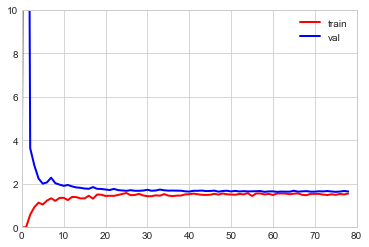

In [31]:
lin_reg = LinearRegression()
plot_learning_curve(lin_reg, X, y, subsample_iters=25)
plt.ylim(0, 10)
plt.show()

The next plot is when a polynomial model with a degree of 2 is used.

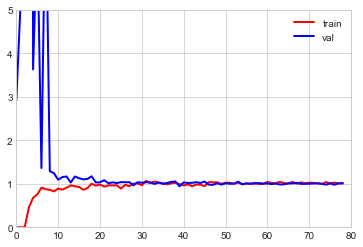

In [32]:
from sklearn.pipeline import Pipeline

polynomial_reg_pipeline = Pipeline((
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('sgd_reg', LinearRegression())
))
plot_learning_curve(polynomial_reg_pipeline, X, y, subsample_iters=25)
plt.ylim(0, 5)
plt.show()

An explanation of what the plot shows:

- For the red training line, it begins at 0 because with a few data points, the model can fit them perfectly. However, when trained with more data, the model makes more and more mistakes until it plateaus.
- The blue validation line shows that the model makes a lot of errors early on, but it eventually gets better at predicting the value for new data with increased training.

The following is an example of a learning curve of a model that is overfit.
The blue line, the learning rate on the validation data, shows that the model makes a lot of errors.

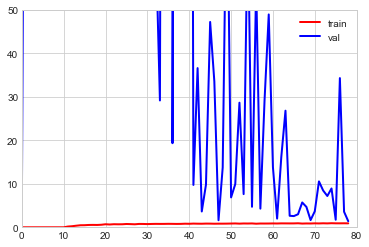

In [33]:
polynomial_reg_pipeline = Pipeline((
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('sgd_reg', LinearRegression())
))
plot_learning_curve(polynomial_reg_pipeline, X, y, subsample_iters=25)
plt.ylim(0, 50)
plt.show()

## Regularized linear models